In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as LA
import gym
import os
import random
import sys
from gym import spaces
from gym.utils import seeding
import copy

from scipy.io import loadmat
import pandapower as pp
import pandapower.networks as pn
import pandas as pd 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cvxpy as cp

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

(CVXPY) Sep 09 04:41:34 PM: Encountered unexpected exception importing solver DIFFCP:
ImportError('diffcp >= 1.0.15 is required')


In [2]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
class VoltageCtrl_nonlinear(gym.Env):
    def __init__(self, pp_net, injection_bus, obs_dim=12, action_dim=12, 
                 v0=1, vmax=1.05, vmin=0.95):
        
        self.network =  pp_net
        self.injection_bus = injection_bus
        self.agentnum = len(injection_bus)
        
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.v0 = v0 
        self.vmax = vmax
        self.vmin = vmin
        
        self.load0_p = np.copy(self.network.load['p_mw'])
        self.load0_q = np.copy(self.network.load['q_mvar'])

        self.gen0_p = np.copy(self.network.sgen['p_mw'])
        self.gen0_q = np.copy(self.network.sgen['q_mvar'])
        
        self.state = np.ones(self.agentnum, )
    
    def step(self, action):
        "State transition dynamics: it takes in the reactive power setpoint"
        "then compute the voltage magnitude at each node via solving power flow"
        
        done = False 
        
        reward = float(-100*LA.norm(self.state-1.0)**2)
        
        # state-transition dynamics
        for i in range(len(self.injection_bus)):
            self.network.sgen.at[i, 'q_mvar'] = action[i] 

        pp.runpp(self.network, algorithm='bfsw', init = 'dc')
        
        self.state = self.network.res_bus.iloc[self.injection_bus].vm_pu.to_numpy()
        
        return self.state, reward, done
    
    def step_load(self, action, load_p, load_q):
        "State transition dynamics: it takes in the reactive power setpoint, and load_p and load_q"
        "compute the voltage magnitude at each node via solving power flow"
        
        done = False 
        
        reward = float(-100*LA.norm(self.state-1.0)**2)
        
        # state-transition dynamics
        for i in range(len(self.injection_bus)):
            self.network.sgen.at[i, 'q_mvar'] = action[i] 
        
        self.network.load['p_mw'] = load_p
        self.network.load['q_mvar'] = load_q

        pp.runpp(self.network, algorithm='bfsw', init = 'dc')
        
        self.state = self.network.res_bus.iloc[self.injection_bus].vm_pu.to_numpy()
        
        return self.state, reward, done

    def step_load_solar(self, action, load_p, load_q, gen_p, gen_q):
        "State transition dynamics: it takes in the reactive power setpoint, load_p and load_q"
        "and gen_p & gen_q to compute the voltage magnitude at each node via solving power flow"
        
        done = False 
        
        reward = float(-100*LA.norm(self.state-1.0)**2)
        
        # state-transition dynamics
        self.network.load['p_mw'] = load_p
        self.network.load['q_mvar'] = load_q
        self.network.sgen['p_mw'] = gen_p
        self.network.sgen['q_mvar'] = gen_q        
        
        for i in range(len(self.injection_bus)):
            self.network.sgen.at[i, 'q_mvar'] += action[i]   

        pp.runpp(self.network, algorithm='bfsw', init = 'dc')
        
        self.state = self.network.res_bus.iloc[self.injection_bus].vm_pu.to_numpy()
        
        return self.state, reward, done
    
    def reset(self, seed=1):
        np.random.seed(seed)
        self.network.sgen['p_mw'] = 0.0
        self.network.sgen['q_mvar'] = 0.0
        self.network.load['p_mw'] = 0.0
        self.network.load['q_mvar'] = 0.0

        
        pp.runpp(self.network, algorithm='bfsw')
        self.state = self.network.res_bus.iloc[self.injection_bus].vm_pu.to_numpy()
        return self.state    

In [4]:
from network_utils import (
    create_56bus,
    create_RX_from_net,
    np_triangle_norm,
    read_load_data)

net = create_56bus()
injection_bus = np.array(range(0, 55))

v_min, v_max = (11.4**2, 12.6**2)  # +/-5%, units kV^2
v_nom = 12**2  # nominal squared voltage magnitude, units kV^2
env = VoltageCtrl_nonlinear(pp_net=net, vmin=v_min, vmax=v_max, v0=v_nom, injection_bus=injection_bus)

### Test with real-world data

In [5]:
import scipy.io as spio
# each row in is a node (1 - 55)
# 6 columns: ['name', 'connectionkW', 'kW', 'pf', 'kVar', 'nameopal']
aggr_p = spio.loadmat('data/aggr_p.mat', squeeze_me=True)['p']  # shape [14421]
aggr_q = spio.loadmat('data/aggr_q.mat', squeeze_me=True)['q']  # shape [14421]
solar = spio.loadmat('data/PV.mat', squeeze_me=True)['actual_PV_profile']  # shape [14421]
load = spio.loadmat('orig_data/loadavail20150908.mat', squeeze_me=True)
scale = 1.1

active_load = np.stack(load['Load']['kW']) / 1000  # to MW
load_p = scale * active_load
reactive_load = np.stack(load['Load']['kVar']) / 1000 # to MVar
load_q = scale * reactive_load


agg_active_load = load_p.sum(axis=0)
assert np.allclose(agg_active_load, aggr_p)
agg_reactive_load = load_q.sum(axis=0)
assert np.allclose(agg_reactive_load, aggr_q)

In [6]:
T = 14421
N = 55
gen_p = np.zeros((N, T))
gen_q = np.zeros((N, T))
solar_orig = spio.loadmat('orig_data/pvavail20150908_2.mat', squeeze_me=True)
capacities = np.array([
    9.97, 11.36, 13.53, 6.349206814, 106.142148, 154, 600, 293.54, 66.045,
    121.588489, 12.94935415, 19.35015173, 100, 31.17327501, 13.06234596,
    7.659505852, 100, 700])  # in kW
capacities /= 1000  # to MW

# for whatever reason, Guanan scales the capacities by a factor of 7
# - see line 39 in dynamic_simu_setting_revision_2nd.m
capacities *= 7

# see Generate_PV_power.m
pv_profile = solar_orig['PVavail'][0]['PVp_6s'] / solar_orig['PVavail'][0]['PVacrate']
pv = pv_profile * capacities.reshape(-1, 1)  # shape [18, 14421]

assert np.allclose(pv.sum(axis=0), solar)

/Users/jing/.conda/envs/untitled/lib/python3.7/site-packages/scipy/io/matlab/mio.py:218: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [7]:
solar_index = np.array([9,12,14,16,19,10,11,13,15,7,2,4,20,23,25,26,32,8]) - 2
gen_p[solar_index,:] = pv

In [8]:
nodal_injection = -load_p + gen_p
pq_fluc = spio.loadmat('data/pq_fluc.mat', squeeze_me=True)['pq_fluc']  # shape [55, 2, 14421]
all_p = pq_fluc[:, 0]  # shape [n, T]
all_q = pq_fluc[:, 1]  # shape [n, T]
assert np.allclose(all_p, nodal_injection) # check if load_p - gen_p = total active injection
assert np.allclose(-load_q, all_q) # reactive power injection does not include any solar

([<matplotlib.axis.XTick at 0x7f81730ac780>,
 [Text(0, 0, '00:00'),
  Text(3600, 0, '06:00'),
  Text(7200, 0, '12:00'),
  Text(10800, 0, '18:00'),
  Text(14400, 0, '24:00')])

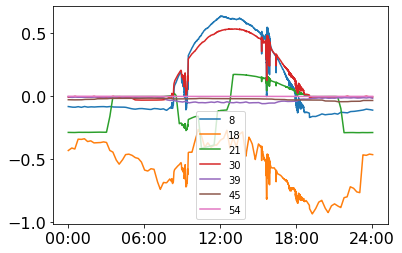

In [9]:
index_list = [8,18,21,30,39,45,54]
for i in index_list:
    plt.plot(nodal_injection[i,:], label = i)

plt.legend()
time = [0, 3600, 7200, 10800, 14400]
labels = ['00:00','06:00','12:00','18:00','24:00']
plt.xticks(time, labels)

### no control

In [10]:
T = 14421

state = env.reset()
episode_reward = 0
episode_control = 0
num_agent = len(injection_bus)
voltage = []
q = []

last_action = np.zeros((num_agent,1))

for t in range(T):
    if(t%1000==0):
        print('Simulated steps', t)
    
    state1 = np.asarray(state-env.vmax)
    state2 = np.asarray(env.vmin-state)
    
    d_v = (np.maximum(state1, 0)-np.maximum(state2, 0)).reshape((num_agent,1))
    
    action = (last_action - 0*d_v)
    
    last_action = np.copy(action)
    
    #next_state, reward, done = env.step_load(action, load_p[:, t], load_q[:, t])
    next_state, reward, done = env.step_load_solar(action, load_p[:, t], load_q[:, t], 
                                                   gen_p[:, t], gen_q[:, t])

    voltage.append(state)

    q.append(action)

    state = next_state
    
    episode_reward += (reward/1000)
    
    episode_control += LA.norm(action, 2)**2

voltage_baseline = np.asarray(voltage)
q_baseline =  np.asarray(q)

Simulated steps 0
Simulated steps 1000
Simulated steps 2000
Simulated steps 3000
Simulated steps 4000
Simulated steps 5000
Simulated steps 6000
Simulated steps 7000
Simulated steps 8000
Simulated steps 9000
Simulated steps 10000
Simulated steps 11000
Simulated steps 12000
Simulated steps 13000
Simulated steps 14000


In [18]:
voltage_baseline.shape


(14421, 55)

([<matplotlib.axis.YTick at 0x7f815b62f9e8>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

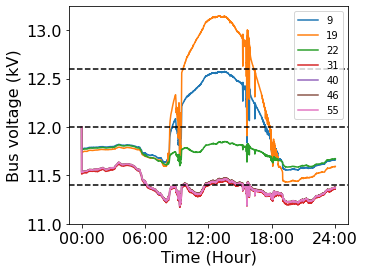

In [17]:

f = plt.figure(figsize=(5, 4))
ax = f.add_subplot(111)

for i in range(len(index_list)):
    plt.plot(12*voltage_baseline[:, index_list[i]], label = index_list[i]+1)
plt.legend(loc = 'upper right')

plt.axhline(y=1.05*12, color='k', linestyle='--', label = 'Upper bound')
plt.axhline(y=0.95*12, color='k', linestyle='--', label = 'Lower bound')
plt.axhline(y=12, color='k', linestyle='--', label = 'Nominal')
plt.ylabel('Bus voltage (kV)')
plt.xlabel('Time (Hour)')

time = [0, 3600, 7200, 10800, 14400]
labels = ['00:00','06:00','12:00','18:00','24:00']
plt.xticks(time, labels)
plt.yticks([11.0, 11.5, 12.0, 12.5, 13.0])
# plt.ylim([11.0, 13.0])

### Test a linear model-based approach: 

#### First use data to learn R and X

In [ ]:
# 1.True R and X
R_mat = spio.loadmat('data/R_13.mat', squeeze_me=True)
X_mat = spio.loadmat('data/X_13.mat', squeeze_me=True)
RR = 2*R_mat['R'][1:,1:]
XX = 2*X_mat['X'][1:,1:]

In [ ]:
# 2. Linear regression based on v = Rp+Xq +v0
P_matrix = gen_p.T - load_p.T
Q_matrix = gen_q.T - load_q.T
V_matrix = voltage_baseline

In [ ]:
### Test the lindist model
t = 6000
V_pred = np.sqrt(RR@P_matrix[t, :]+XX@Q_matrix[t, :]+12**2)/12
plt.plot(V_matrix[t+1,:], label = 'True V')
plt.plot((V_pred), label = 'Predicted V')
plt.legend()

In [19]:
# least square solution for R and X
X = np.hstack([P_matrix[0:-1,:], Q_matrix[0:-1,:]])
Y = (V_matrix[1:,:]*12)**2-12**2

alpha = np.dot((np.dot(np.linalg.pinv(np.dot(X.T, X), rcond=1e-5), X.T)), Y)
#print(alpha)

R_hat = alpha[0:12,:]
X_hat = alpha[12:,:]

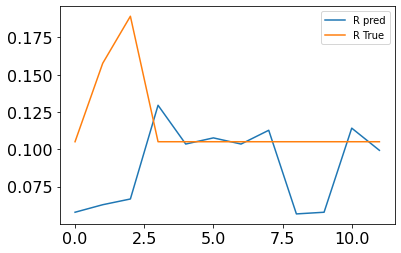

In [20]:
index = 2
plt.plot(R_hat[index,:], label = 'R pred')
plt.plot(RR[index,:], label = 'R True')
plt.legend()

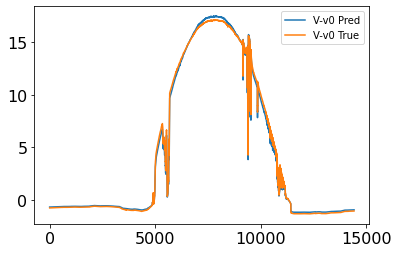

In [21]:
y_pred = X@alpha
plt.plot(y_pred[:, index], label = 'V-v0 Pred')
plt.plot(Y[:, index], label = 'V-v0 True')
plt.legend()

#### Remark. 
We might not be able to get an accurate estimation for R and X as p, q are correlated; but the voltage prediction from v = Rp + Xq +v0 is accurate

In [77]:
import cvxpy as cp

In [92]:
### model based controller based on the groundtruth X and R matrices

T = 14421

state = env.reset0()
episode_reward = 0
episode_control = 0
num_agent = len(injection_bus)
voltage = []
q = []

v_max = 12.6**2 - 12**2
v_min = 11.4**2 - 12**2

for t in range(T):
    if(t%1000==0):
        print('Simulated steps', t)
    
    state1 = np.asarray(state-env.vmax)
    state2 = np.asarray(env.vmin-state)
    
    d_v = (np.maximum(state1, 0)-np.maximum(state2, 0)).reshape((num_agent,1))
    
    action = 0*d_v #(last_action - 0*d_v)
    
    # Project the action into a safety set
    action_pi = np.squeeze(action)
    x = cp.Variable(N)
    P = np.eye(N)
    load_pt = load_p[:, t]
    load_qt = load_q[:, t]
    gen_pt = gen_p[:, t]
    gen_qt = gen_q[:, t]
    
    prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x-action_pi, P)),
                     [RR@(gen_pt-load_pt)+XX@(x+gen_qt-load_qt) <= v_max,
                      RR@(gen_pt-load_pt)+XX@(x+gen_qt-load_qt) >= v_min])
    prob.solve()
    action_proj = x.value
    
    action_proj2 = np.expand_dims(action_proj, axis=1)
    
    #print('Original action', action_pi, 'Projection', action_proj)
    
    
    #next_state, reward, done = env.step_load(action, load_p[:, t], load_q[:, t])
    next_state, reward, done = env.step_load_solar(action_proj2, load_p[:, t], load_q[:, t], 
                                                   gen_p[:, t], gen_q[:, t])

    voltage.append(state)

    q.append(action_proj2)

    state = next_state
    
    episode_reward += (reward/1000)
    
    episode_control += LA.norm(action_proj2, 2)**2

voltage_baseline_safe = np.asarray(voltage)
q_baseline_safe =  np.asarray(q)

Simulated steps 0
Simulated steps 1000
Simulated steps 2000
Simulated steps 3000
Simulated steps 4000
Simulated steps 5000
Simulated steps 6000
Simulated steps 7000
Simulated steps 8000
Simulated steps 9000
Simulated steps 10000
Simulated steps 11000
Simulated steps 12000
Simulated steps 13000
Simulated steps 14000


([<matplotlib.axis.YTick at 0x13d052c40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

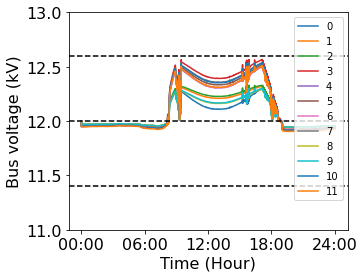

In [93]:
index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

f = plt.figure(figsize=(5, 4))
ax = f.add_subplot(111)

for i in range(len(index)):
    plt.plot(12*voltage_baseline_safe[:, index[i]], label = index[i])
plt.legend(loc = 'upper right')

plt.axhline(y=1.05*12, color='k', linestyle='--', label = 'Upper bound')
plt.axhline(y=0.95*12, color='k', linestyle='--', label = 'Lower bound')
plt.axhline(y=12, color='k', linestyle='--', label = 'Nominal')
plt.ylabel('Bus voltage (kV)')
plt.xlabel('Time (Hour)')

time = [0, 3600, 7200, 10800, 14400]
labels = ['00:00','06:00','12:00','18:00','24:00']
plt.xticks(time, labels)
plt.yticks([11.0, 11.5, 12.0, 12.5, 13.0])
# plt.ylim([11.0, 13.0])